In [1]:
import numpy as np
import tensorflow.keras as keras
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
best_callBack = np.asarray([])
History = {"accurcy":[],"loss":[]}

In [4]:
def inverse_probability(epsilon, x_0, x_min, x_max):
    y = np.random.rand(len(x_min))
    a = (x_max - x_0) / epsilon
    b = (x_min - x_0) / epsilon
    return epsilon * np.tan(y * np.arctan(a) + (1.0 - y) * np.arctan(b)) + x_0

def __dispersion(length, initial_population_size,dispersion_a, dispersion_b):
    kk = length - 100 + 1
    return kk ** (-dispersion_a - dispersion_b * kk)

In [12]:
def SoFA( fitFunction, length, lowerBoundaries, upperBoundaries, scbd = 0.01, initial_population_size = 100, max_iter = 10000):
    points = [np.random.uniform(lowerBoundaries,upperBoundaries,length) for i in range(initial_population_size)]
    fitnesses = np.asarray([fitFunction(_) for _ in points])
    fittestValue = np.max(fitnesses)
    worestValue = np.min(fitnesses)
    print("first = %f " % (-fittestValue))
    fittestPoint = points[np.argmin(fitnesses)]
    width = fittestValue - worestValue
    numerator = ((fitnesses-worestValue) / width) ** len(fitnesses)
    denominator = np.sum(numerator)
    probabilities = numerator / denominator
    dispersion_a = 0.4
    dispersion_b = 2.5e-6
    counter = 0
    epsilon = __dispersion(len(points), initial_population_size,dispersion_a, dispersion_b)
    while(epsilon>=scbd and counter < max_iter):
        counter +=1
        index = np.random.choice(len(points), p=probabilities)
        newPoint = inverse_probability(epsilon,points[index],lowerBoundaries,upperBoundaries)
        newFitness = fitFunction(newPoint)
        points.append(newPoint) 
        fitnesses = np.insert(fitnesses,len(fitnesses),newFitness)
        if newFitness > fittestValue :
            fittestPoint = newPoint
            best_callBack = newPoint
            fittestValue = newFitness
            print("iteration %d : %f worest = %f chosen = %f" % (counter, -fittestValue, -worestValue, -fitnesses[index]))
        elif newFitness < worestValue :
            worestValue = newFitness
        width = fittestValue - worestValue
        numerator = ((fitnesses-worestValue) / width) ** len(fitnesses)
        denominator = np.sum(numerator)
        probabilities = numerator / denominator
        epsilon = __dispersion(len(points), initial_population_size,dispersion_a, dispersion_b)
    print("Done at : %d" % (counter))
    return [fittestPoint, fittestValue]

In [6]:
# Loading the MNIST data set with samples and splitting it
mnist = keras.datasets.mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()      
#Here x is the png and y is the clasification

# Normalizing the data (making length = 1)
X_train = keras.utils.normalize(X_train, axis=1)   
X_test = keras.utils.normalize(X_test, axis=1)

In [7]:
# Create a neural network model
# Add one flattened input layer for the pixels
# Add two dense hidden layers
# Add one dense output layer for the 10 digits
NN = keras.models.Sequential()
NN.add(keras.layers.Flatten(input_shape=(28, 28)))
NN.add(keras.layers.Dense(units=128, activation='relu'))
NN.add(keras.layers.Dense(units=64, activation='relu'))
NN.add(keras.layers.Dense(units=32, activation='relu'))
NN.add(keras.layers.Dense(units=10, activation='softmax')) #Clasificación

# Compiling and optimizing model
NN.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 111,146
Trainable params: 111,146
Non-trainable params: 0
_________________________________________________________________


In [8]:
def get_shape(model):
    weights_layer = model.get_weights()
    shapes = []
    for weights in weights_layer:
        shapes.append(weights.shape)
    return shapes

def set_shape(weights, shapes):
    new_weights = []
    index = 0
    for shape in shapes:
        if (len(shape) > 1):
            n_nodes = np.prod(shape) + index
        else:
            n_nodes = shape[0] + index
        tmp = np.array(weights[index:n_nodes]).reshape(shape)
        new_weights.append(tmp)
        index = n_nodes
    return new_weights

In [9]:
shapes = get_shape(NN)

In [11]:
def evaluate_nn(W):
    NN.set_weights(set_shape(W, shapes))
    score = NN.evaluate(X_train, Y_train, verbose=0)
    History['loss'].append(score[0])
    History['accurcy'].append(score[1])
    return score[1]

In [13]:
max_=np.ones(111146)
min_= max_ * -1
result=SoFA(evaluate_nn,111146,min_,max_)
NN.set_weights(set_shape(result[0], shapes))
score = NN.evaluate(X_test, Y_test )
print('Test loss:', score[0])
print('Test accuracy:', score[1])

first = -0.161500 
iteration 43 : -0.177967 worest = -0.056433 chosen = -0.161500
iteration 313 : -0.205883 worest = -0.051683 chosen = -0.177967
iteration 465 : -0.218817 worest = -0.051683 chosen = -0.205883
iteration 590 : -0.220267 worest = -0.051683 chosen = -0.218817
iteration 599 : -0.226933 worest = -0.051683 chosen = -0.220267
iteration 711 : -0.227500 worest = -0.051683 chosen = -0.226933
iteration 751 : -0.231700 worest = -0.051683 chosen = -0.227500
iteration 791 : -0.235950 worest = -0.051683 chosen = -0.231700
iteration 886 : -0.244317 worest = -0.051683 chosen = -0.235950
iteration 897 : -0.245067 worest = -0.051683 chosen = -0.244317
iteration 1038 : -0.256850 worest = -0.051683 chosen = -0.244317
iteration 1296 : -0.260683 worest = -0.051683 chosen = -0.256850
iteration 1299 : -0.265117 worest = -0.051683 chosen = -0.260683
iteration 1604 : -0.265850 worest = -0.051683 chosen = -0.265117
iteration 1705 : -0.272067 worest = -0.051683 chosen = -0.265850
iteration 1965 : 

In [24]:
import matplotlib.pyplot as plt

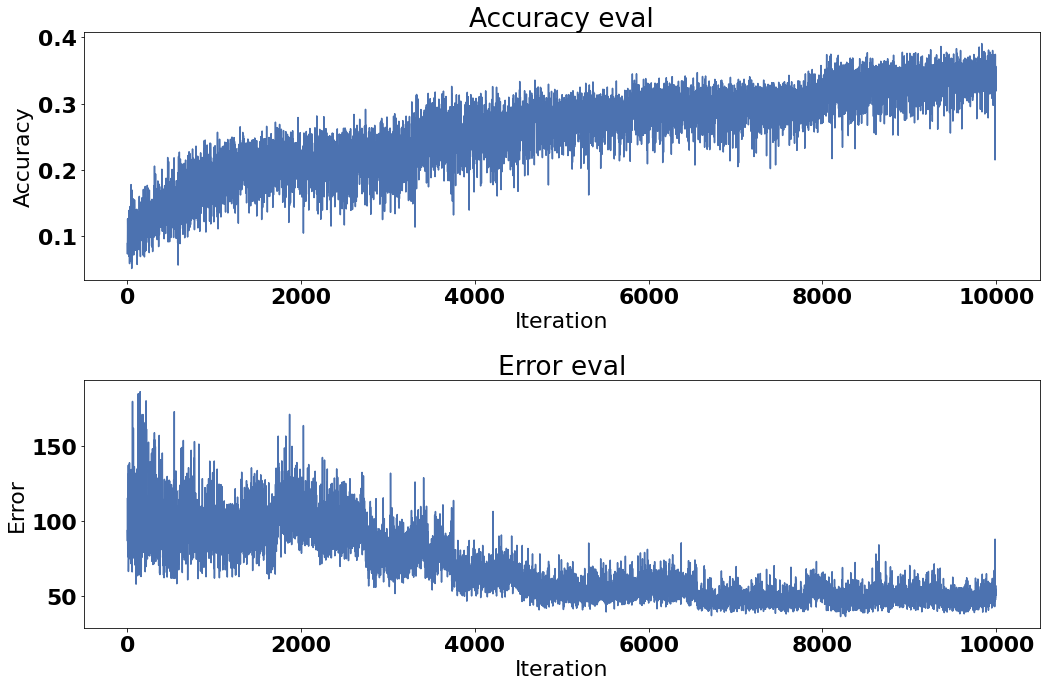

In [78]:
fig, axs = plt.subplots(2,figsize=(15,10))

    # create accuracy sublpot
axs[0].plot(History['accurcy'])
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Accuracy eval")
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Accuracy')

    # create error sublpot
axs[1].plot(History['loss'])
axs[1].set_ylabel("Error")
axs[1].set_xlabel("Iteration")
axs[1].set_title("Error eval")

fig.tight_layout()

plt.show()

In [44]:
#Predicting the labels-DIGIT
y_predict = NN.predict(X_test)
y_predict=np.argmax(y_predict, axis=1) # Here we get the index of maximum value in the encoded vector
y_test_digit_eval=np.argmax(X_test, axis=1)

In [46]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

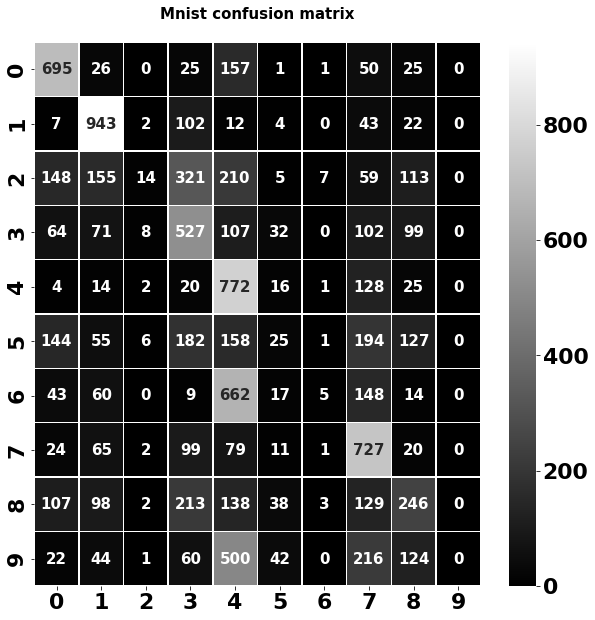

In [79]:
con_mat=confusion_matrix(Y_test,y_predict)
plt.style.use('seaborn-deep')
plt.figure(figsize=(10,10))
sns.heatmap(con_mat,annot=True,annot_kws={'size': 15},linewidths=0.5,fmt="d",cmap="gray")
plt.title('Mnist confusion matrix\n',fontweight='bold',fontsize=15)
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


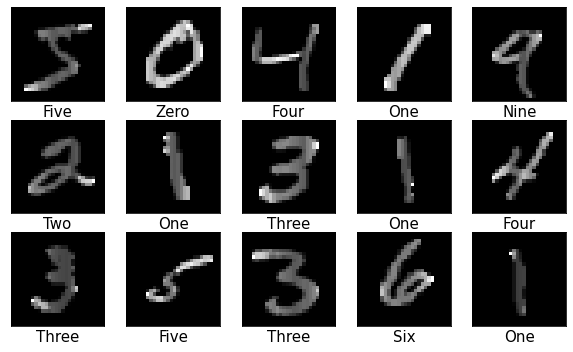

<Figure size 432x288 with 0 Axes>

In [66]:
col_names = ['Zero','One','Two','Three','Four','Five','Six','Seven','Eight','Nine']

#Visualizing the digits
plt.figure(figsize=(10,10))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i], cmap='gray')
    plt.xlabel(col_names[Y_train[i]],fontsize=15)

plt.show()
plt.savefig('minst.png')